# Preparation

data classes, general functions

In [466]:
from __future__ import annotations

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random

from enum import Enum, auto
from dataclasses import dataclass
from typing import List
from collections import Counter

In [467]:
KNN_TRAIN = "./mnist_small/train.csv"
KNN_TEST = "./mnist_small/test.csv"

names = ["label"] + [f"Pix {i}" for i in range(28*28)]

train_df = pd.read_csv(KNN_TRAIN, names=names)
test_df = pd.read_csv(KNN_TEST, names=names)

## Coding part
The following sections contain the coding part of the project

* Image visualization (helper tool)

In [468]:
def visualize_image(array: np.ndarray):
    """Visualize the given flattened image. Assume 28*28 len"""
    image = array.reshape(28, 28)

    plt.figure()
    plt.title(f"Cluster center") 
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)

    plt.show(True)

def add_cluster_center_as_ax(cluster_center: np.ndarray, cluster_index: int, ax):
    image = cluster_center.reshape(28, 28)

    ax.set_title(f"Clust.{cluster_index}")
    ax.imshow(image, cmap='gray', vmin=0, vmax=255)

* trivial score computation

In [469]:
class ClusterValidation(Enum):
    C_INDEX = auto()
    DUNN_INDEX = auto()
    DAVIS_BOULDIN = auto()

class TerminateCondition(Enum):
    CHANGED_CLUSTER = 0b01
    CHANGED_CENTER = 0b10

@dataclass
class Score():
    """Hold the score for a training set evalutation. Contain the score evalutation method"""
    total: int
    success: int
    failures: int

    accuracy: float

    @classmethod
    def compute_score(total: int, successes: int, failures: int) -> Score:
        """Compute the score from the given successes / failures
        
        Returns
        -----
            A score object containing the information
        """
        accuracy = successes / total

        return Score(total, successes, failures, accuracy)

* Custom classifier, heavily coupled to test dataset but optimized for efficient tests on k via memoization of the distance map

In [470]:
class KmeansClassifier:
    """Class encapsulating the logic of the KNN algorithm"""
    #Work with arrays to be more efficient
    data: np.ndarray
    labels: np.ndarray

    cluster_map: np.ndarray

    def __init__(self, train_df: pd.DataFrame) -> None:
        """Init the KNN classifier with the training and testing dataset"""
        self.labels = train_df.loc[:, 'label'].to_numpy()
        self.data = train_df.drop(['label'], axis=1, inplace=False).to_numpy()
        print(f"K-means loaded with {len(self.data)} data")

    def euclidian_distances(self, point: np.ndarray, matrix: np.ndarray):
        """Compute the distance as the difference in intensity level pixel-wise between the input datapoint and the given matrix.
        
        Returns
        ----
            A matrix of distance between the point and each matrix's data point.
            The matrix thus has a size of (N, 1): I column as the distance is a singular value,
            N rows as each row is the distance to a matrix's datapoint
        """
        #use numpy functions as they are made to be efficient with vecotrized input
        return np.sqrt(np.sum(np.power(np.subtract(point, matrix), 2), axis=1))

    def is_terminated(self, i: int, i_max: int, has_changed_cluster: bool, has_changed_center: bool, 
        terminate_flags: List[TerminateCondition]) -> bool:
        if i >= i_max:
            print(f"Max iterations reached: {i}")
            return True
        if TerminateCondition.CHANGED_CLUSTER in terminate_flags:
            if not has_changed_cluster:
                print(f"No cluster changes detected")
                return True
        if TerminateCondition.CHANGED_CENTER in terminate_flags:
            if not has_changed_center:
                print(f"No center changes detected")
                return True
        return False

    def clusterize(self, k: int, iterations: int, terminate_flags: List[TerminateCondition]) -> Tuple[np.ndarray, np.ndarray]:
        """Classify each item on the test dataset and yields an evaluation score
        
        Args
        -----
            k: int - The number of expected clusters
            iterations: int - 
            terminate_condition: int - Additional terminate condition, see Terminate condition enums

        Returns
        ----
            A score object
        """
        #Chose k random centers, init clusters with single point. Avoid same-point centers
        rand_indexes = []
        for _ in range(k):
            randToss = None
            while randToss is None or randToss in rand_indexes:
                randToss = random.randrange(0, len(self.data))
            rand_indexes.append(randToss)

        centers = np.take(self.data, rand_indexes, axis=0)
            
        #Init "cluster identification" array for each datapoint
        self.cluster_map = np.zeros((len(self.data)), dtype=int)

        has_changed_cluster = True
        has_changed_center = True

        i = 0
        while not self.is_terminated(i, iterations, has_changed_cluster, has_changed_center, terminate_flags):
            i += 1
            print(f"\rIteration <{i:5}>", end="")
            has_changed_cluster = False
            has_changed_center = False

            #Reassign each point to centers
            for point_index, point in enumerate(self.data):
                #Calculate distance map
                point_centers_dist_matrix = self.euclidian_distances(point, centers)

                #Find index of nearest center, that's the new cluster index
                new_cluster_index = np.argmin(point_centers_dist_matrix)

                #Verify if it has changed
                current_cluster_index = self.cluster_map[point_index]
                if current_cluster_index != new_cluster_index:
                    has_changed_cluster = True
                    self.cluster_map[point_index] = new_cluster_index

            #Re-calculate centers
            for cluster_index in range(k):
                #Get all data assigned to this cluster using ndarray binary mask on cluster index
                cluster_points = self.data[self.cluster_map == cluster_index]
                #cluster_points = np.take(self.data, (self.cluster_map == cluster_index), axis=0)

                #Center is simply the new mean of this data
                new_cluster_mean = np.mean(cluster_points, axis=0)

                #Track wheter the center has changed
                current_cluster_mean = centers[cluster_index]
                if not np.array_equal(current_cluster_mean, new_cluster_mean):
                    has_changed_center = True
                    centers[cluster_index] = new_cluster_mean

        return self.cluster_map, centers

# Assignnement
Test the model accuracy with different cluster validation methods

* Validation Values for K = {5, 7, 9, 10, 12, 15}

K-means loaded with 1000 data
Iteration <   20>No cluster changes detected


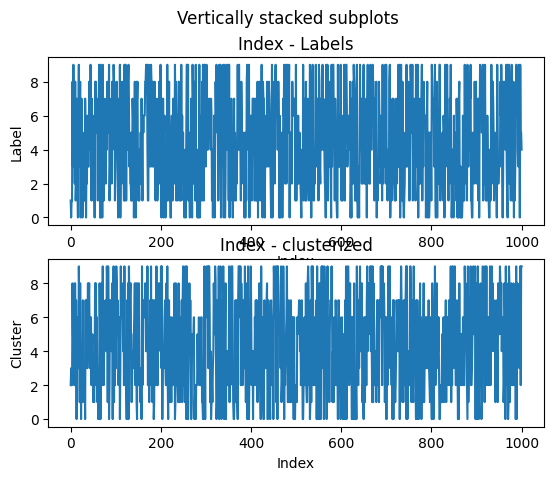

In [471]:
kmeans_classifier = KmeansClassifier(train_df)

clusters = 10
max_iter = 100

cluster_map, cluster_centers = kmeans_classifier.clusterize(clusters, max_iter, (TerminateCondition.CHANGED_CENTER, TerminateCondition.CHANGED_CLUSTER))

colors = [f"C{i}" for i in range(9)]

labels = train_df.loc[:, 'label'].to_numpy()

fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')

axs[0].plot(np.linspace(0, len(train_df), len(train_df)), labels)
axs[0].set_title("Index - Labels")
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Label")

axs[1].plot(np.linspace(0, len(train_df), len(train_df)), cluster_map)
axs[1].set_title("Index - clusterized")
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Cluster")

plt.show()


Analysing class 0
Label 0 has 84 elements. They are spread around 4 clusters
Cluster spread: [(3, 44), (5, 34), (7, 4), (1, 2)]
Class 0 is mostly represented by cluster 3 : 44/84 (52.38)%

Analysing class 1
Label 1 has 125 elements. They are spread around 4 clusters
Cluster spread: [(2, 118), (1, 4), (6, 2), (7, 1)]
Class 1 is mostly represented by cluster 2 : 118/125 (94.40)%

Analysing class 2
Label 2 has 111 elements. They are spread around 8 clusters
Cluster spread: [(6, 64), (8, 17), (5, 11), (2, 7), (7, 6), (9, 3), (1, 2), (0, 1)]
Class 2 is mostly represented by cluster 6 : 64/111 (57.66)%

Analysing class 3
Label 3 has 100 elements. They are spread around 7 clusters
Cluster spread: [(7, 63), (5, 19), (1, 8), (8, 4), (9, 4), (0, 1), (2, 1)]
Class 3 is mostly represented by cluster 7 : 63/100 (63.00)%

Analysing class 4
Label 4 has 93 elements. They are spread around 7 clusters
Cluster spread: [(9, 43), (4, 18), (0, 16), (3, 10), (2, 3), (1, 2), (6, 1)]
Class 4 is mostly represe

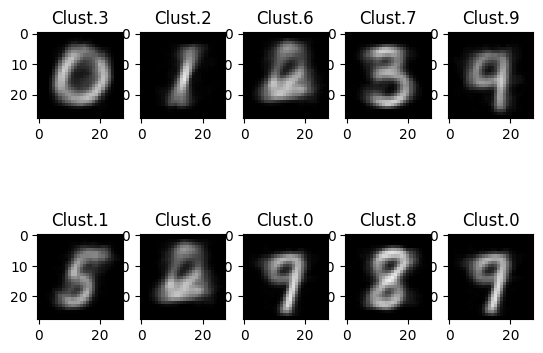

In [472]:
fig, axs = plt.subplots(2, 5)

for i in range(2):
    for j in range(5):
        class_value = 5*i + j
        print(f"\nAnalysing class {class_value}")
        binary_mask = (labels == class_value)
        cluster_values = cluster_map[binary_mask]
        print(f"Label {class_value} has {np.count_nonzero(binary_mask)} elements. They are spread around {len(np.unique(cluster_values))} clusters")
        
        sorted_freq_labels = Counter(cluster_values).most_common()
        most_freq_cluster = int(sorted_freq_labels[0][0])

        print(f"Cluster spread: {sorted_freq_labels}")
        counts = [count for val, count in sorted_freq_labels]
        together_ratio = 100 * (counts[0] / sum(counts))
        print(f"Class {class_value} is mostly represented by cluster {most_freq_cluster} : {counts[0]}/{sum(counts)} ({together_ratio:.2f})%")

        center = cluster_centers[most_freq_cluster]
        add_cluster_center_as_ax(center, most_freq_cluster, axs[i][j])

plt.show()

# Display all clusters to have an idea of the final repartition

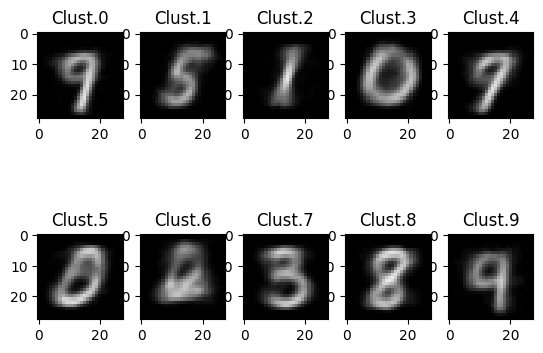

In [473]:
fig, axs = plt.subplots(2, 5)

for i in range(2):
    for j in range(5):
        cluster_ind = 5*i + j

        add_cluster_center_as_ax(cluster_centers[cluster_ind], cluster_ind, axs[i][j])

plt.show()